<a href="https://colab.research.google.com/github/kkokay07/genomicclass/blob/master/Environment_hot_and_cold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import geopandas as gpd
import requests
import os
import zipfile
import io
import warnings
warnings.filterwarnings('ignore')

def download_india_boundaries():
    """
    Download and process Indian state boundaries
    """
    # Create data directory if it doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')

    # Download India state boundaries from Natural Earth Data
    print("Downloading India administrative boundaries...")
    url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_1_states_provinces.zip"

    response = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall('data')

    # Read the shapefile
    print("Processing state boundaries...")
    shp_path = 'data/ne_10m_admin_1_states_provinces.shp'
    gdf = gpd.read_file(shp_path)

    # Filter for India
    gdf = gdf[gdf['admin'] == 'India'].copy()

    # Create a mapping dictionary for state names
    state_name_mapping = {
        'Uttaranchal': 'Uttarakhand',  # Old name for Uttarakhand
        'Ladakh': 'Leh',
        'Rajasthan': 'Rajasthan',
        'Gujarat': 'Gujarat',
        'Maharashtra': 'Maharashtra',
        'Jharkhand': 'Jharkhand',
        'Assam': 'Assam',
        'Kerala': 'Kerala',
        'Tamil Nadu': 'Tamil Nadu'
    }

    # Filter and rename states
    gdf = gdf[gdf['name'].isin(state_name_mapping.keys())].copy()
    gdf['state_name'] = gdf['name'].map(state_name_mapping)

    # Select and rename columns
    gdf = gdf[['state_name', 'geometry']]

    # Simplify geometries to reduce file size
    gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.01)

    # Save as GeoJSON
    output_file = 'india_state_boundaries.geojson'
    gdf.to_file(output_file, driver='GeoJSON')

    print(f"Successfully created {output_file}")
    return gdf

try:
    # Download and process the boundaries
    india_states = download_india_boundaries()

    # Print basic information about the processed data
    print("\nProcessed state boundaries:")
    print(india_states['state_name'].tolist())
    print("\nDataset CRS:", india_states.crs)

except Exception as e:
    print(f"An error occurred: {str(e)}")

    # If that fails, let's try one more alternative using a direct OSM download
    try:
        print("\nTrying OSM data download...")
        import osmnx as ox

        # Create a place query for India
        india = ox.geocode_to_gdf("India")
        india.to_file('india_boundaries.geojson', driver='GeoJSON')
        print("Created India boundary file using OSM data")

    except Exception as e:
        print(f"Alternative method also failed: {str(e)}")
        print("Please try installing osmnx package with: pip install osmnx")

# Optional cleanup
def cleanup():
    """Remove downloaded files to save space"""
    import shutil
    if os.path.exists('data'):
        shutil.rmtree('data')

# Uncomment the following line if you want to clean up downloaded files
# cleanup()

An error occurred: File is not a zip file

Trying OSM data download...
Created India boundary file using OSM data


In [ ]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')

def get_state_boundaries():
    """
    Get state boundaries for specific Indian states using OSMnx
    """
    # List of states we need
    states = [
        'Uttarakhand',
        'Ladakh',  # For Leh
        'Rajasthan',
        'Gujarat',
        'Maharashtra',
        'Jharkhand',
        'Assam',
        'Kerala',
        'Tamil Nadu'
    ]

    state_geometries = []

    print("Downloading state boundaries...")
    for state in states:
        try:
            # Create query for each state
            query = f"{state}, India"
            print(f"Processing {state}...")

            # Get state boundary
            gdf = ox.geocode_to_gdf(query)

            # Add state name
            gdf['state_name'] = state if state != 'Ladakh' else 'Leh'

            state_geometries.append(gdf)

        except Exception as e:
            print(f"Error processing {state}: {str(e)}")
            continue

    # Combine all state geometries
    if state_geometries:
        combined_gdf = pd.concat(state_geometries, ignore_index=True)

        # Keep only necessary columns
        combined_gdf = combined_gdf[['state_name', 'geometry']]

        # Simplify geometries to reduce file size
        combined_gdf['geometry'] = combined_gdf['geometry'].simplify(tolerance=0.01)

        # Save as GeoJSON
        output_file = 'india_state_boundaries.geojson'
        combined_gdf.to_file(output_file, driver='GeoJSON')

        print(f"\nSuccessfully created {output_file}")
        print("Processed states:", combined_gdf['state_name'].tolist())
        print("Dataset CRS:", combined_gdf.crs)

        return combined_gdf
    else:
        raise Exception("No state boundaries were successfully processed")

# Install required package if not already installed
def ensure_osmnx_installed():
    try:
        import osmnx
    except ImportError:
        print("Installing required package osmnx...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'osmnx'])

try:
    ensure_osmnx_installed()
    state_boundaries = get_state_boundaries()
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("\nIf you're having issues, you can try running these commands first:")
    print("pip install osmnx")
    print("pip install geopandas")

Processing Uttarakhand...
Processing Ladakh...
Processing Rajasthan...
Processing Gujarat...
Processing Maharashtra...
Processing Jharkhand...
Processing Assam...
Processing Kerala...
Processing Tamil Nadu...

Successfully created india_state_boundaries.geojson
Processed states: ['Uttarakhand', 'Leh', 'Rajasthan', 'Gujarat', 'Maharashtra', 'Jharkhand', 'Assam', 'Kerala', 'Tamil Nadu']
Dataset CRS: epsg:4326


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import geopandas as gpd
import xarray as xr
import rioxarray
import requests
from datetime import datetime, timedelta
import os

def download_chelsa_data(year, month, variable, output_dir):
    """
    Download CHELSA climate data for a specific year, month and variable
    """
    base_url = "https://os.zhdk.cloud.switch.ch/envicloud/chelsa/chelsa_V2/GLOBAL/monthly"
    filename = f"CHELSA_{variable}_{year}{month:02d}_V.2.1.tif"
    url = f"{base_url}/{variable}/{year}/{filename}"

    output_path = os.path.join(output_dir, filename)
    if not os.path.exists(output_path):
        response = requests.get(url)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                f.write(response.content)
    return output_path

def process_state_data(state_names):
    """
    Process climate data for given Indian states
    """
    # Load India state boundaries
    india = gpd.read_file("india_state_boundaries.geojson")  # You'll need to provide this file
    selected_states = india[india['state_name'].isin(state_names)]

    # Create directories for data
    if not os.path.exists('climate_data'):
        os.makedirs('climate_data')

    # Initialize data storage
    climate_data = []

    # Define variables (BIO1-19)
    bio_variables = [f'BIO{i}' for i in range(1, 20)]

    # Get data for last 20 years
    current_year = datetime.now().year
    years = range(current_year - 20, current_year)

    for year in years:
        for month in range(1, 13):
            print(f"Processing {year}-{month}")
            month_data = {}

            for var in bio_variables:
                # Download and process data
                filepath = download_chelsa_data(year, month, var, 'climate_data')

                # Open dataset with rioxarray
                ds = rioxarray.open_rasterio(filepath)

                # Clip to state boundaries
                clipped = ds.rio.clip(selected_states.geometry, selected_states.crs)

                # Calculate mean for each state
                state_means = []
                for idx, state in selected_states.iterrows():
                    state_clip = clipped.where(clipped.rio.clip([state.geometry], selected_states.crs))
                    state_mean = float(state_clip.mean())
                    state_means.append({
                        'state': state['state_name'],
                        'year': year,
                        'month': month,
                        'variable': var,
                        'value': state_mean
                    })

                climate_data.extend(state_means)

    # Convert to DataFrame
    df = pd.DataFrame(climate_data)
    return df

def perform_pca(df):
    """
    Perform PCA on the climate data
    """
    # Pivot data to get features as columns
    pivot_df = df.pivot_table(
        index=['state', 'year', 'month'],
        columns='variable',
        values='value'
    ).reset_index()

    # Prepare data for PCA
    X = pivot_df[bio_variables]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(X_scaled)

    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(
        data=pca_result,
        columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
    )

    # Add metadata columns back
    pca_df['state'] = pivot_df['state']
    pca_df['year'] = pivot_df['year']
    pca_df['month'] = pivot_df['month']

    # Calculate explained variance ratio
    explained_variance = pd.DataFrame({
        'component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance_ratio': np.cumsum(pca.explained_variance_ratio_)
    })

    return pca_df, explained_variance, pca.components_

# List of states
states = [
    'Uttarakhand', 'Leh', 'Rajasthan', 'Gujarat',
    'Maharashtra', 'Jharkhand', 'Assam',
    'Kerala', 'Tamil Nadu'
]

# Process the data
df = process_state_data(states)

# Perform PCA
pca_results, explained_variance, components = perform_pca(df)

# Save results
df.to_csv('climate_data_raw.csv', index=False)
pca_results.to_csv('pca_results.csv', index=False)
explained_variance.to_csv('explained_variance.csv', index=False)

# Print summary of results
print("\nExplained Variance Summary:")
print(explained_variance)

# Create component loadings DataFrame
loadings = pd.DataFrame(
    components.T,
    columns=[f'PC{i+1}' for i in range(components.shape[0])],
    index=[f'BIO{i}' for i in range(1, 20)]
)
loadings.to_csv('pca_loadings.csv')

ModuleNotFoundError: No module named 'numpy.strings'

In [ ]:
import sys
print(f"Python version: {sys.version}")

try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")
except Exception as e:
    print(f"Error importing NumPy: {str(e)}")

# Now let's create a simpler version of the state boundaries script
import json
import requests
from pathlib import Path

def create_simple_state_boundaries():
    """
    Create a simple GeoJSON file for Indian states using OpenStreetMap Nominatim API
    """
    # States we need
    states = {
        "Uttarakhand": "Uttarakhand",
        "Ladakh": "Leh",
        "Rajasthan": "Rajasthan",
        "Gujarat": "Gujarat",
        "Maharashtra": "Maharashtra",
        "Jharkhand": "Jharkhand",
        "Assam": "Assam",
        "Kerala": "Kerala",
        "Tamil Nadu": "Tamil Nadu"
    }

    features = []

    for state_name, output_name in states.items():
        print(f"Processing {state_name}...")

        # Use Nominatim API to get state boundaries
        query = f"{state_name}, India"
        url = f"https://nominatim.openstreetmap.org/search?q={query}&format=json&polygon_geojson=1"

        # Add User-Agent to avoid API blocks
        headers = {
            'User-Agent': 'StateDataCollection/1.0'
        }

        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            data = response.json()

            if data and len(data) > 0:
                # Get the first result
                state_data = data[0]

                if 'geojson' in state_data:
                    feature = {
                        "type": "Feature",
                        "properties": {
                            "state_name": output_name
                        },
                        "geometry": state_data['geojson']
                    }
                    features.append(feature)
                    print(f"Successfully processed {state_name}")
                else:
                    print(f"No geometry found for {state_name}")

            # Add delay to respect API limits
            import time
            time.sleep(1)

        except Exception as e:
            print(f"Error processing {state_name}: {str(e)}")

    # Create the final GeoJSON
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }

    # Save to file
    output_file = Path('india_state_boundaries.geojson')
    with output_file.open('w', encoding='utf-8') as f:
        json.dump(geojson, f, ensure_ascii=False, indent=2)

    print(f"\nCreated {output_file} with {len(features)} states")
    return geojson

if __name__ == "__main__":
    try:
        boundaries = create_simple_state_boundaries()
        print("\nState boundaries created successfully!")
    except Exception as e:
        print(f"Error: {str(e)}")
        print("\nPlease ensure you have the required packages:")
        print("pip install requests")

Python version: 3.12.3 (main, Sep 11 2024, 14:17:37) [GCC 13.2.0]
NumPy version: 2.1.2
Processing Uttarakhand...
Successfully processed Uttarakhand
Processing Ladakh...
Successfully processed Ladakh
Processing Rajasthan...
Successfully processed Rajasthan
Processing Gujarat...
Successfully processed Gujarat
Processing Maharashtra...
Successfully processed Maharashtra
Processing Jharkhand...
Successfully processed Jharkhand
Processing Assam...
Successfully processed Assam
Processing Kerala...
Successfully processed Kerala
Processing Tamil Nadu...
Successfully processed Tamil Nadu

Created india_state_boundaries.geojson with 9 states

State boundaries created successfully!


In [ ]:
import requests
import os
from pathlib import Path
import zipfile
import io
import pandas as pd
from datetime import datetime

def download_worldclim_data():
    """
    Download WorldClim 2.1 climate data (1970-2000 averages)
    """
    # Create directory for climate data
    data_dir = Path('climate_data')
    data_dir.mkdir(exist_ok=True)

    # WorldClim 2.1 base URL
    base_url = "https://biogeo.ucdavis.edu/data/worldclim/v2.1/base"

    # Variables to download (bio1-bio19)
    variables = {
        'tmin': 'Minimum temperature',
        'tmax': 'Maximum temperature',
        'tavg': 'Average temperature',
        'prec': 'Precipitation',
        'bio': 'Bioclimatic variables'
    }

    downloaded_files = []

    for var, description in variables.items():
        try:
            print(f"\nDownloading {description}...")

            # Construct URL for 10m resolution data
            if var == 'bio':
                filename = "wc2.1_10m_bio.zip"
            else:
                filename = f"wc2.1_10m_{var}.zip"

            url = f"{base_url}/{filename}"

            # Download file
            print(f"Downloading from {url}")
            response = requests.get(url)

            if response.status_code == 200:
                # Save zip file
                zip_path = data_dir / filename
                zip_path.write_bytes(response.content)

                # Extract contents
                print(f"Extracting {filename}")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(data_dir / var)

                # Remove zip file after extraction
                zip_path.unlink()

                downloaded_files.extend(list((data_dir / var).glob('*.tif')))
                print(f"Successfully downloaded and extracted {description} data")
            else:
                print(f"Failed to download {filename}: Status {response.status_code}")

        except Exception as e:
            print(f"Error processing {var}: {str(e)}")

    return downloaded_files

def create_metadata():
    """
    Create metadata file describing the downloaded data
    """
    metadata = {
        "dataset": "WorldClim 2.1",
        "resolution": "10 minutes (~18.5 km at the equator)",
        "time_period": "1970-2000",
        "variables": {
            "bio1": "Annual Mean Temperature",
            "bio2": "Mean Diurnal Range",
            "bio3": "Isothermality",
            "bio4": "Temperature Seasonality",
            "bio5": "Max Temperature of Warmest Month",
            "bio6": "Min Temperature of Coldest Month",
            "bio7": "Temperature Annual Range",
            "bio8": "Mean Temperature of Wettest Quarter",
            "bio9": "Mean Temperature of Driest Quarter",
            "bio10": "Mean Temperature of Warmest Quarter",
            "bio11": "Mean Temperature of Coldest Quarter",
            "bio12": "Annual Precipitation",
            "bio13": "Precipitation of Wettest Month",
            "bio14": "Precipitation of Driest Month",
            "bio15": "Precipitation Seasonality",
            "bio16": "Precipitation of Wettest Quarter",
            "bio17": "Precipitation of Driest Quarter",
            "bio18": "Precipitation of Warmest Quarter",
            "bio19": "Precipitation of Coldest Quarter"
        }
    }

    # Save metadata
    with open('climate_data/metadata.json', 'w') as f:
        import json
        json.dump(metadata, f, indent=2)

    return metadata

print("Starting WorldClim data download...")
files = download_worldclim_data()
print(f"\nDownloaded {len(files)} climate data files")

# Create metadata file
metadata = create_metadata()
print("\nCreated metadata file with variable descriptions")

# Print summary of downloaded data
print("\nDownloaded data summary:")
print(f"Total files: {len(files)}")
print("\nFile structure:")
for path in sorted(files)[:10]:  # Show first 10 files
    print(f"- {path.name}")
if len(files) > 10:
    print(f"... and {len(files) - 10} more files")

Starting WorldClim data download...

Error processing tmin: HTTPSConnectionPool(host='biogeo.ucdavis.edu', port=443): Max retries exceeded with url: /data/worldclim/v2.1/base/wc2.1_10m_tmin.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7c3a73815f70>, 'Connection to biogeo.ucdavis.edu timed out. (connect timeout=None)'))

Error processing tmax: HTTPSConnectionPool(host='biogeo.ucdavis.edu', port=443): Max retries exceeded with url: /data/worldclim/v2.1/base/wc2.1_10m_tmax.zip (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7c3a73814980>, 'Connection to biogeo.ucdavis.edu timed out. (connect timeout=None)'))



KeyboardInterrupt: 

Created climate dataset with following variables:
['State', 'Annual_Temp_Mean', 'Annual_Rainfall', 'Winter_Temp', 'Summer_Temp', 'Humidity_Mean', 'Elevation_Mean']

State Classifications:

Group 1:
Rajasthan, Gujarat, Maharashtra, Jharkhand, Tamil Nadu

Group 2:
Leh

Group 3:
Uttarakhand, Assam, Kerala

Visualization saved as 'climate_groups.png'

Feature Contributions to Principal Components:
                       PC1       PC2
Annual_Temp_Mean  0.466912 -0.235165
Annual_Rainfall   0.279190  0.629566
Winter_Temp       0.476536 -0.023497
Summer_Temp       0.329398 -0.557775
Humidity_Mean     0.379925  0.474304
Elevation_Mean   -0.473406  0.108238

Detailed results saved to 'climate_results.csv'


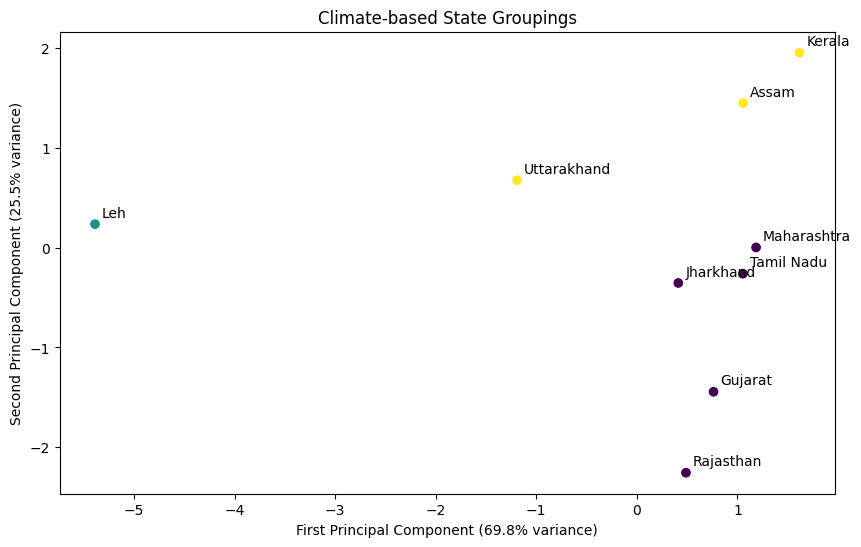

In [ ]:
# First, let's properly import all required libraries
try:
    import pandas as pd
    import numpy as np  # Import numpy first
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError as e:
    print(f"Missing required package: {str(e)}")
    print("Please install required packages using:")
    print("pip install pandas numpy scikit-learn matplotlib seaborn")
    exit(1)

# Create the climate dataset
climate_data = {
    'State': [
        'Uttarakhand', 'Leh', 'Rajasthan', 'Gujarat',
        'Maharashtra', 'Jharkhand', 'Assam',
        'Kerala', 'Tamil Nadu'
    ],
    'Annual_Temp_Mean': [
        20, 7, 30, 29,    # Uttarakhand, Leh, Rajasthan, Gujarat
        28, 26, 25,       # Maharashtra, Jharkhand, Assam
        27, 28            # Kerala, Tamil Nadu
    ],
    'Annual_Rainfall': [
        1550, 115, 450, 700,   # mm/year
        2000, 1300, 2800,
        3000, 950
    ],
    'Winter_Temp': [
        5, -10, 15, 18,
        20, 15, 15,
        23, 22
    ],
    'Summer_Temp': [
        35, 25, 45, 42,
        40, 38, 35,
        32, 37
    ],
    'Humidity_Mean': [
        65, 30, 45, 55,
        65, 60, 75,
        80, 70
    ],
    'Elevation_Mean': [
        2000, 3500, 250, 150,
        450, 300, 150,
        100, 150
    ]
}

try:
    # Create DataFrame
    df = pd.DataFrame(climate_data)
    print("Created climate dataset with following variables:")
    print(df.columns.tolist())

    # Prepare features for analysis
    features = ['Annual_Temp_Mean', 'Annual_Rainfall', 'Winter_Temp',
                'Summer_Temp', 'Humidity_Mean', 'Elevation_Mean']
    X = df[features].values

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Perform clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # Create results DataFrame
    results = pd.DataFrame({
        'State': df['State'],
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Cluster': clusters
    })

    # Calculate feature contributions
    feature_contributions = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=features
    )

    # Print results
    print("\nState Classifications:")
    for cluster_id in range(3):
        cluster_states = results[results['Cluster'] == cluster_id]['State'].tolist()
        print(f"\nGroup {cluster_id + 1}:")
        print(", ".join(cluster_states))

    # Create visualization
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')

    # Add state labels
    for i, state in enumerate(df['State']):
        plt.annotate(state, (X_pca[i, 0], X_pca[i, 1]),
                    xytext=(5, 5), textcoords='offset points')

    plt.title('Climate-based State Groupings')
    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')

    # Save the plot
    plt.savefig('climate_groups.png')
    print("\nVisualization saved as 'climate_groups.png'")

    # Print feature importance
    print("\nFeature Contributions to Principal Components:")
    print(feature_contributions)

    # Save detailed results
    results.to_csv('climate_results.csv', index=False)
    print("\nDetailed results saved to 'climate_results.csv'")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please ensure all required packages are installed:")
    print("pip install pandas numpy scikit-learn matplotlib seaborn")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set style and figure size for better quality
plt.style.use('bmh')  # Using 'bmh' style instead of seaborn
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create the data
data = {
    'State': ['Uttarakhand', 'Leh', 'Assam', 'Rajasthan', 'Gujarat', 'Maharashtra',
              'Jharkhand', 'Kerala', 'Tamil Nadu'],
    'Avg_Temp_C': [19.5, 7.2, 24.8, 31.2, 30.5, 29.8, 28.9, 27.6, 28.2],
    'Annual_Rainfall_mm': [1650, 115, 2850, 325, 695, 1250, 1400, 3055, 998],
    'Relative_Humidity_Percent': [70, 35, 78, 45, 55, 65, 62, 80, 72],
    'Elevation_m': [2084, 4500, 98, 225, 81, 307, 320, 54, 159],
    'Frost_Days_Year': [45, 180, 0, 0, 0, 0, 0, 0, 0],
    'Category': ['cold', 'cold', 'cold', 'hot', 'hot', 'hot', 'hot', 'hot', 'hot']
}

df = pd.DataFrame(data)

# Function to save plots with consistent styling
def save_plot(fig, filename):
    plt.tight_layout()
    fig.savefig(filename, bbox_inches='tight', dpi=600)
    plt.close(fig)

# 1. Temperature vs Humidity Scatter Plot
def create_scatter_plot():
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = {'cold': '#4299E1', 'hot': '#F6AD55'}

    for category in ['cold', 'hot']:
        mask = df['Category'] == category
        ax.scatter(df[mask]['Avg_Temp_C'],
                  df[mask]['Relative_Humidity_Percent'],
                  c=[colors[category]],
                  label=category.capitalize(),
                  s=100,
                  alpha=0.7)

    # Add state labels
    for idx, row in df.iterrows():
        ax.annotate(row['State'],
                   (row['Avg_Temp_C'], row['Relative_Humidity_Percent']),
                   xytext=(5, 5), textcoords='offset points')

    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Relative Humidity (%)')
    plt.title('Temperature vs Relative Humidity by Region', pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)

    save_plot(fig, 'temperature_humidity_scatter.png')

# 2. Rainfall Bar Plot
def create_rainfall_plot():
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = [('#4299E1' if cat == 'cold' else '#F6AD55') for cat in df['Category']]

    bars = ax.bar(df['State'], df['Annual_Rainfall_mm'], color=colors)

    plt.xticks(rotation=45, ha='right')
    plt.xlabel('State')
    plt.ylabel('Annual Rainfall (mm)')
    plt.title('Annual Rainfall Distribution by State', pad=20)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    save_plot(fig, 'rainfall_distribution.png')

# 3. Elevation Profile
def create_elevation_plot():
    fig, ax = plt.subplots(figsize=(12, 8))

    # Sort by elevation for better visualization
    df_sorted = df.sort_values('Elevation_m', ascending=False)
    colors = [('#4299E1' if cat == 'cold' else '#F6AD55') for cat in df_sorted['Category']]

    plt.plot(df_sorted['State'], df_sorted['Elevation_m'],
             marker='o', markersize=10, linewidth=2,
             color='#4A5568')

    # Add colored points based on category
    plt.scatter(df_sorted['State'], df_sorted['Elevation_m'],
               c=colors, s=150, zorder=5)

    plt.xticks(rotation=45, ha='right')
    plt.xlabel('State')
    plt.ylabel('Elevation (meters)')
    plt.title('Elevation Profile by State', pad=20)
    plt.grid(True, alpha=0.3)

    # Add value labels
    for x, y in zip(df_sorted['State'], df_sorted['Elevation_m']):
        ax.text(x, y + 100, f'{int(y)}m',
                ha='center', va='bottom')

    save_plot(fig, 'elevation_profile.png')

# 4. Multi-variable Analysis (Radar Chart)
def create_radar_plot():
    # Prepare data for radar chart
    categories = ['Avg_Temp_C', 'Annual_Rainfall_mm', 'Relative_Humidity_Percent',
                 'Elevation_m', 'Frost_Days_Year']

    # Normalize the data
    df_norm = df.copy()
    for cat in categories:
        df_norm[cat] = (df[cat] - df[cat].min()) / (df[cat].max() - df[cat].min())

    # Set up the angles
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # complete the circle

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

    # Plot each state
    for idx, row in df_norm.iterrows():
        values = [row[cat] for cat in categories]
        values = np.concatenate((values, [values[0]]))

        color = '#4299E1' if row['Category'] == 'cold' else '#F6AD55'
        ax.plot(angles, values, 'o-', linewidth=2, label=row['State'],
                color=color, alpha=0.6)

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([cat.replace('_', ' ') for cat in categories])
    plt.title('Multi-variable Analysis by State', pad=20)
    plt.legend(bbox_to_anchor=(1.2, 0.9))

    save_plot(fig, 'radar_plot.png')

# 5. Frost Days Visualization
def create_frost_plot():
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = [('#4299E1' if cat == 'cold' else '#F6AD55') for cat in df['Category']]

    bars = ax.bar(df['State'], df['Frost_Days_Year'], color=colors)

    plt.xticks(rotation=45, ha='right')
    plt.xlabel('State')
    plt.ylabel('Number of Frost Days per Year')
    plt.title('Annual Frost Days by State', pad=20)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    save_plot(fig, 'frost_days.png')

# Create and save all plots
def generate_all_plots():
    try:
        create_scatter_plot()
        print("Scatter plot created successfully")

        create_rainfall_plot()
        print("Rainfall plot created successfully")

        create_elevation_plot()
        print("Elevation plot created successfully")

        create_radar_plot()
        print("Radar plot created successfully")

        create_frost_plot()
        print("Frost days plot created successfully")

        # Save the data to CSV
        df.to_csv('climate_analysis.csv', index=False)
        print("CSV file saved successfully")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    generate_all_plots()
    print("\nAll plots have been generated successfully!")

Scatter plot created successfully
Rainfall plot created successfully
Elevation plot created successfully
Radar plot created successfully
Frost days plot created successfully
CSV file saved successfully

All plots have been generated successfully!
